In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Create dataset

Before getting started, let's create a simple stationary dataset of a signal we're all familiar with: a sine wave.  Below we create 20 examples of sinusoidal signals of frequency 1Hz and a zero mean.  Then we added some stochastic characteristics both in terms of random kicks at each time step (sampling at 100Hz over 20 seconds) and phase shifts.

In [74]:
from mk_wave import *
import matplotlib.pyplot as plt

# parameters
freq = 1 # Hz
amp, signal_mean, noise_std = 1, 0, 0.1 # desired units
fs = 100 # Hz
total_time= 20 # sec

# create matrix of zeros to store signals
N = int(total_time * fs) # length of signals
num_samples = 20 # batch size
data = np.zeros((N,num_samples))

for i in range(num_samples):
    t, data[:,i] = mk_wave(freq, amp, noise_std, signal_mean, fs, 
                           total_time, phase_shift = True)

Some examples... very contrived but it's better to start with simple systems while one is trying something new.

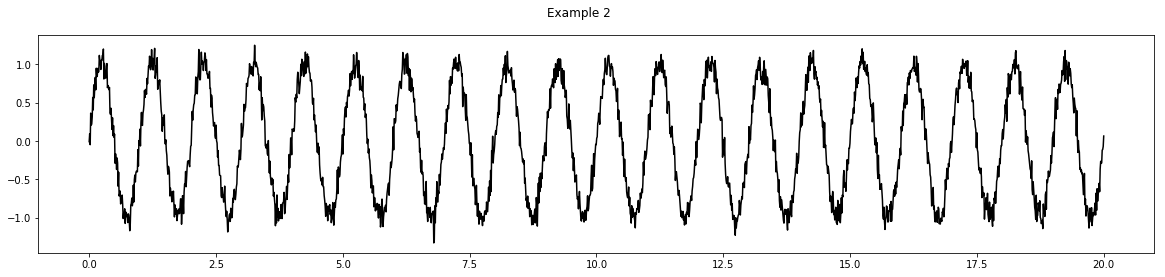

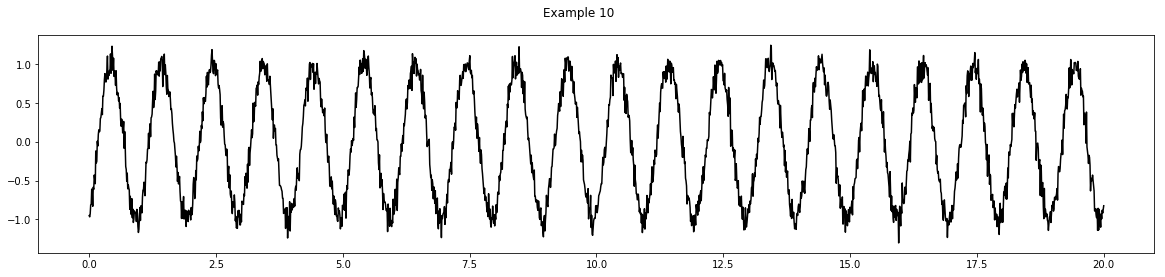

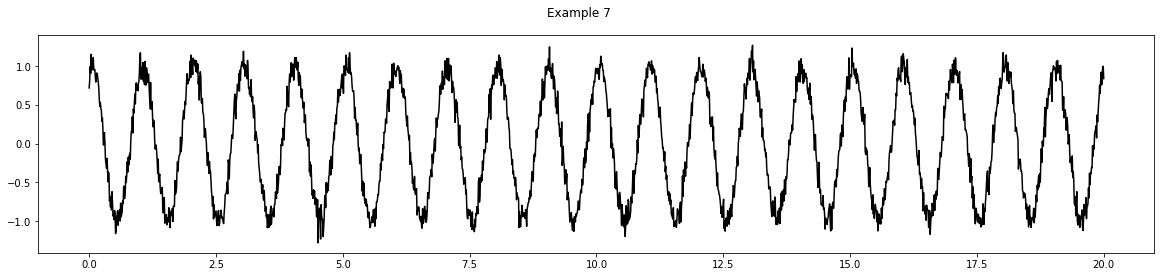

In [73]:
for i in np.random.randint(num_samples,size = (3)):
    plt.figure(figsize=(20,4))
    plt.plot(t,data[:,i], c='k')
    plt.suptitle(f'Example {i}')

# Convolutional Models

## Theoretical Background

A convolution model of length Q or MA(Q) model treats the predictions $\hat Y[t]$ as a convolution of the input X[0..t] with a filter h[1...Q] of **finite length** Q. First, we use the convolution formula 

\begin{equation*}
\hat Y_t= \sum_{q=0}^Q X[q] h[t-q]
\end{equation*}

along with least squares minimization to estimate the filter h from training data X, Y

\begin{equation*}
h = min_h \sum_t |Y_t - \hat Y_t | ^2  + \lambda \sum_s | h[s] |
\end{equation*}

The second penalty term is included to regularize the estimation process, make it stable and provide meaningful generalization / learning ability. We motivation the use of this regularization in a later section.

We then use the convolution formula above to do forecasting. As noted above, if X[t] is of dimension M and Y[t] is of dimension N then h[t] is a matrix of shape M x N.

## Our Example

For our univariate, sine-generating system, the problem is framed in the following way. Since we don't have any exogenous data, we will build a model that uses the previous $q$ time steps as our input $X[t...t-q]$ and the next future time step is our "target" (i.e. $Y_t= X_{t+1}$).

## Defining the Forward function

The convenience of the pytorch environment allows us to approximate $h$ by simply defining the forward pass function (i.e. the convolution formula above) and the parameters for the optimization of the weights (i.e. optimization class, loss function, etc).  The autograd and optim packages handle all the finer details and are completely abstracted away from the user as we will see later.

First, let's define a forward pass function for our univariate system that we suspect to be MA in nature.

In [4]:
import torch
import torch.nn as nn

In [151]:
def forward(X, weights):
    '''     
    Parameters
    ----------
    X
        input dims : (time x batch_size)

    Returns
    -------
    Ys
        output dims : (time x batch_size)
    '''
    Q = weights.shape[0]
    
    # grab T and batch_size from X
    T, batch_size = X.shape[0], X.shape[1]
    # create tensor to store y values with Yo concat to beginning
    Ys = torch.zeros(T,batch_size)

    # make predictions with current state of weights
    for t in range(Q,T):
        for q in range(Q):
            Ys[t] += X[t - q - 1] * weights[q]

    return Ys

Thus, if we wanted to make a prediction, we would simply call this function as we would any other.  Note that the way we have coded the above, the first two predicts of y will be 0's still and thus should be ignored. Otherwise, the other thing to mention is that a nn.Module expects that X be a torch.Tensor which is basically a special kind of matrix that allows for the backend of torch to make magic happen.

In [152]:
Q = 2
weights = torch.randn(Q)

X = torch.from_numpy(data).float()

y_preds = forward(X,weights)

y_preds.shape

torch.Size([2000, 20])

Note the elegance of this model as it can be coded in a few simple lines of python code.  However, pytorch's autograd and optim packages create an environment where the user does not need to consider model complexity as a crutch towards prototyping/benchmarking different model architectures.  The steps for optimizing the above are the same as a multi-layer recurring neural network.

## Optimizing the weights

### Creating a custom torch.nn module



In [210]:
class MAq(nn.Module):
    '''
    MA Module
    ---------

    Solves:
        Y_t = \sum_q B_q X_{t-q}
    
    Dimensions (assume univariate):
        time -> 0-th dim
        batch -> 1-st dim

    Parameters
    ----------
        Q: length of convolution filter
    '''

    def __init__(self, Q):
        super(MAq, self).__init__( )
        self.Q = Q
        self._weights = nn.Parameter(torch.rand(Q)) # normal dist with mean,var ~(0,1)

    def forward(self, X):
        '''     
        Parameters
        ----------
        X
            input dims : (time x batch_size)

        Returns
        -------
        Ys
            output dims : (time x batch_size)
        '''
        # grab T and batch_size from X
        T, batch_size = X.shape[0], X.shape[1]
        # create tensor to store y values with Yo concat to beginning
        Ys = torch.zeros(T,batch_size)

        # make predictions with current state of weights
        for t in range(Q,T):
            for q in range(Q):
                Ys[t] += X[t - q - 1] * self._weights[q] # "-1" because t is in y_space

        return Ys

see that if we give it a dataset, the forward pass function is called and we are given the output (while any other modifications that are made by forward are stored within). Again, we need to throw out the first Q predictions for y since they are 0's anyways. IN addition, we don't know the future yet so the final prediction is not included in our y_true either.  So after some indexing... we have our X, y_true matrices (may not have to explain any of this)

In [222]:
Q = 10
X = data
y_true = data[Q:]

# numpy to torch tensor
X = torch.from_numpy(X).float()
y_true = torch.from_numpy(y_true).float()

# make some predictions
model = MAq(Q)
y_preds = model(X)[Q:]

X.shape, y_true.shape, y_preds.shape

(torch.Size([2000, 20]), torch.Size([1990, 20]), torch.Size([1990, 20]))

In [212]:
for i in model.parameters():
    print(i)

Parameter containing:
tensor([0.3058, 0.2449, 0.6019, 0.6339, 0.0835, 0.1581, 0.0687, 0.6641, 0.2533,
        0.9625], requires_grad=True)


### Computing the loss

In [213]:
def mse(y_preds,y_t): return torch.mean((y_preds-y_t)**2)

loss = mse(y_preds,y_true)
loss

tensor(4.5160, grad_fn=<MeanBackward0>)

And to add a regularization term to the loss we would simply pass true loss and the parameters we wish to subject to L2 regularization to the following

In [214]:
def l2_reg(loss, params, lambda_l2):
    '''L2 regularization on given params'''
    
    for p in params: 
        loss += torch.sum(p**2) * lambda_l2
    
    return loss

l2_reg(loss, model.parameters(), lambda_l2=0.01)

tensor(4.5398, grad_fn=<AddBackward0>)

### Visualizing unoptimized output 
note that you have to detach to plot

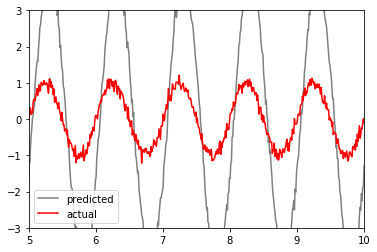

In [216]:
plt.plot(t[Q:],y_preds[:,0].detach(),c='k',alpha=0.5)
plt.plot(t[Q:],y_true[:,0].detach(),c='r')

plt.ylim([-3,3])
plt.xlim([5,10])
plt.legend(['predicted','actual'])

### Taking a step

First part is to define an optimization algo, and learning rate (Sean puts in a few sentences but mostly refers away for this)

backward is automatically calculated with the first call on the loss variable and then the optimizer can take a step based on the parameters given above

In [217]:
lr =0.1
optimiser = torch.optim.Adam(model.parameters(),amsgrad=True)
optimiser.param_groups[0]['lr'] = lr

model.zero_grad()

# take an optimization step based on back prop results
loss.backward()
optimiser.step()

Make a new a prediction, calculate the loss

In [218]:


# make predictions
y_preds = model(X)[Q:]

# calculate loss
loss = mse(y_preds,y_true)
print(loss)

# add regularization term to loss (after recording)
params = model.parameters()
loss = l2_reg(loss, params,lambda_l2=0.01)


tensor(2.0858, grad_fn=<MeanBackward0>)


If we were to visualize another step it would look like... we can see that it's doing visibly a lot better in addition to significantly lower loss (pre regularization)

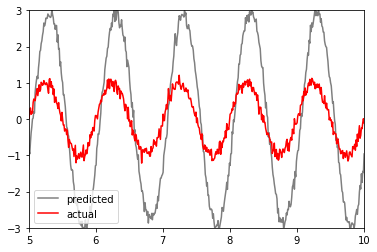

In [219]:
# plot results
plt.plot(t[Q:],y_preds[:,0].detach(),c='k',alpha=0.5)
plt.plot(t[Q:],y_true[:,0].detach(),c='r')

plt.ylim([-3,3])
plt.xlim([5,10])
plt.legend(['predicted','actual'])

## Putting it all together

same Q from above

In [226]:
lr = 0.05
lam = 0.005
epochs = 50

model = MAq(Q)


optimiser = torch.optim.Adam(model.parameters(),amsgrad=True)
optimiser.param_groups[0]['lr'] = lr 

loss_record = []


for epoch in range(epochs):
    model.zero_grad()

    # make predictions
    y_preds = model(X)[Q:]

    # calculate/record loss
    loss = mse(y_preds,y_true)
    loss_record.append(loss)
    
    # add regularization term to loss (after recording)
    params = model.parameters()
    loss = l2_reg(loss, params,lam)

    # take an optimization step based on back prop results
    loss.backward()
    optimiser.step()

### Tracking Loss

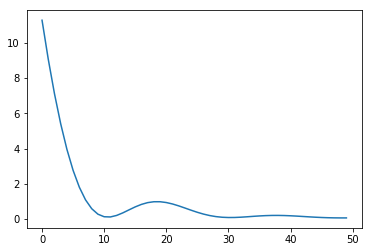

In [233]:
plt.plot(loss_record)

### Visualizing Output

note that it's just giving back the last value (overfitting)

(-3, 3)

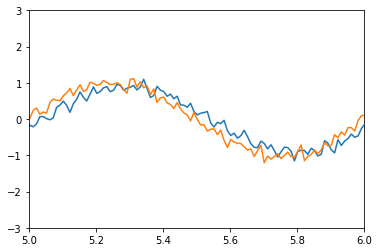

In [229]:
plt.plot(t[Q:],y_preds[:,0].detach())
plt.plot(t[Q:],y_true[:,0].detach())
plt.xlim([5,6])
plt.ylim([-3,3])

In [230]:
[p for p in model.parameters()]

[Parameter containing:
 tensor([ 0.3101, -0.0306,  0.2631,  0.1354, -0.2915, -0.3746,  0.4364,  0.3920,
          0.3505, -0.3306], requires_grad=True)]

# Intro to AR models


HAVENT STARTED HERE YET...


$\hat Y_t = \sum_{p=1}^{P} A_p Y_{t-p}  + X_t $

$\min_A  \sum_t | Y_{t} - \hat Y_t |^2 + \lambda \sum_p | A_p |
$

In [ ]:
class ARp

In [25]:
Ys = torch.rand(4,2)
Xs = torch.ones(4,2)*2

In [26]:
Y = torch.cat( [Ys,Xs], dim=1 )
Y

tensor([[5.6708e-01, 6.5394e-01, 2.0000e+00, 2.0000e+00],
        [4.4620e-01, 5.9884e-01, 2.0000e+00, 2.0000e+00],
        [1.9980e-03, 2.9092e-01, 2.0000e+00, 2.0000e+00],
        [2.1194e-01, 7.8267e-01, 2.0000e+00, 2.0000e+00]])

In [27]:
Y_t = X_t
for p in range( P ):
    Y_t += Ys[t - p - 1] * weights[p]

NameError: name 'X_t' is not defined

Thus if I wanted to make a prediction with this model I would simply need to look back at the last p values predicted by the model and multiply them by our optimized weight array

In [23]:
Ys * Xs

tensor([[1.4501, 1.8345],
        [0.9730, 0.0034],
        [0.0208, 0.5084],
        [1.2224, 1.4222]])